In [1]:
import tensorflow as tf
import fasttext
import numpy as np
import pickle
import jieba
import pandas as pd
import keras
from keras.utils import to_categorical
from keras.layers import Input,Dense,Conv1D,MaxPooling1D,Flatten,Dropout,concatenate
from keras.models import Model
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score,recall_score,f1_score

/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/weiyu/anaconda3/envs/tensorflow

# 加载数据

In [2]:
#加载数据
with open("./data/data_input.pkl", "rb") as f:
    text_train, label_train, text_test, label_test, label_names = pickle.load(f)

In [3]:
#加载停用词
stopwords=pd.read_csv("./data/stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

# 数据预处理

In [4]:
#分词
def text_to_token(line):
    words = jieba.lcut(line)
    tokens = np.array([x for x in words if x not in stopwords])
    return tokens

In [5]:
x_train_token=np.array([text_to_token(x) for x in text_train])
x_test_token=np.array([text_to_token(x) for x in text_test])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpcsxzw1e_' -> '/tmp/jieba.cache'
Loading model cost 1.069 seconds.
Prefix dict has been built successfully.


In [6]:
model=fasttext.load_model("./model/model_fasttext.bin")

In [7]:
sequence_len=100
embedding_size=300
#处理成定长
def get_embedding(line):
    word_vec=np.zeros([sequence_len,embedding_size])
    for i in range(sequence_len):
        if(i<len(line)):
            word_vec[i]=model[line[i]]
        else:
            word_vec[i]=model["blank"]
    return word_vec

In [8]:
x_train = np.array([get_embedding(x) for x in x_train_token])
x_test = np.array([get_embedding(x) for x in x_test_token])

In [9]:
y_train = to_categorical(label_train)
y_test = to_categorical(label_test)

In [10]:
y_train.shape

(5734, 45)

In [11]:
#写入文件
print("writing data to fasttext format...")
with open('./data/data.pkl', 'wb') as f:
    pickle.dump([x_train,y_train,x_test,y_test],f)
print("done!")

writing data to fasttext format...
done!


# 训练模型

In [12]:
# 使用gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 设置定量的GPU使用量
config = tf.ConfigProto()
session = tf.Session(config=config)

# 设置最少显存
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [13]:
#textCNN
input_layer = Input(shape=(sequence_len,embedding_size), dtype='float')
cnn1 = Conv1D(256, 3, padding='same', strides=1, activation='relu')(input_layer)
cnn1 = MaxPooling1D(pool_size=48)(cnn1)
cnn2 = Conv1D(256, 4, padding='same', strides=1, activation='relu')(input_layer)
cnn2 = MaxPooling1D(pool_size=47)(cnn2)
cnn3 = Conv1D(256, 5, padding='same', strides=1, activation='relu')(input_layer)
cnn3 = MaxPooling1D(pool_size=46)(cnn3)
# 合并三个模型的输出向量
cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
flat = Flatten()(cnn)
drop = Dropout(0.2)(flat)
output_layer = Dense(len(label_names), activation='softmax')(drop)

model=Model(input_layer,output_layer)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(x_train, y_train, batch_size=32, epochs=10,validation_split=0.1)

Train on 5160 samples, validate on 574 samples
Epoch 1/10
5160/5160 [==============================] - 11s 2ms/step - loss: 2.0774 - acc: 0.4638 - val_loss: 1.5092 - val_acc: 0.5557
Epoch 2/10
5160/5160 [==============================] - 11s 2ms/step - loss: 1.0110 - acc: 0.6990 - val_loss: 1.3444 - val_acc: 0.5993
Epoch 3/10
5160/5160 [==============================] - 11s 2ms/step - loss: 0.5595 - acc: 0.8442 - val_loss: 1.3607 - val_acc: 0.5714
Epoch 4/10
5160/5160 [==============================] - 11s 2ms/step - loss: 0.2879 - acc: 0.9403 - val_loss: 1.2652 - val_acc: 0.5941
Epoch 5/10
5160/5160 [==============================] - 10s 2ms/step - loss: 0.1545 - acc: 0.9744 - val_loss: 1.2986 - val_acc: 0.6045
Epoch 6/10
5160/5160 [==============================] - 10s 2ms/step - loss: 0.0984 - acc: 0.9882 - val_loss: 1.3042 - val_acc: 0.6028
Epoch 7/10
5160/5160 [==============================] - 10s 2ms/step - loss: 0.0626 - acc: 0.9938 - val_loss: 1.3335 - val_acc: 0.6080
Epoch 8/

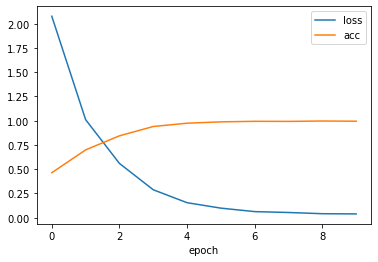

In [15]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["acc"],label="acc")
plt.xlabel('epoch')
plt.legend()

# 测试

In [21]:
result = model.predict(x_test)
y_predict = np.argmax(result, axis=1)  
from sklearn.metrics import classification_report
print(classification_report(y_pred= y_predict, y_true=label_test))

              precision    recall  f1-score   support

           0       0.57      0.83      0.67       254
           1       0.66      0.76      0.71       374
           2       0.50      0.37      0.43       310
           3       0.45      0.49      0.47       280
           4       0.62      0.70      0.66       276
           5       0.57      0.77      0.65       175
           6       0.53      0.66      0.59       159
           7       0.39      0.58      0.46       190
           8       0.32      0.32      0.32       164
           9       0.32      0.19      0.24       113
          10       0.76      0.75      0.76       145
          11       0.51      0.55      0.53        47
          12       0.20      0.11      0.14        28
          13       0.62      0.76      0.68        83
          14       0.12      0.03      0.05        60
          15       0.25      0.04      0.07        24
          16       0.70      0.66      0.68        85
          17       0.58    